## Importing Libraries & Building the Dataset Pipeline

In [64]:
import tensorflow as tf 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [65]:
df = pd.read_csv("../dataset/metadata.csv")

In [66]:
test_df = df[df["split"] == "test"]
trainval_df = df[df["split"] == "train"]

###  Splitting the training data into training and validation sets (80/20 split).

In [67]:
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [68]:
train_df.head()

,image_id,split,sat_image_path,mask_path
5070,829196,train,train/829196_sat.jpg,train/829196_mask.png
5895,947864,train,train/947864_sat.jpg,train/947864_mask.png
2344,434989,train,train/434989_sat.jpg,train/434989_mask.png
5014,823500,train,train/823500_sat.jpg,train/823500_mask.png
1921,373567,train,train/373567_sat.jpg,train/373567_mask.png


In [69]:
test_df.head()

,image_id,split,sat_image_path,mask_path
7469,100393,test,test/100393_sat.jpg,NaN
7470,100995,test,test/100995_sat.jpg,NaN
7471,101982,test,test/101982_sat.jpg,NaN
7472,10206,test,test/10206_sat.jpg,NaN
7473,102240,test,test/102240_sat.jpg,NaN


In [70]:
def get_full_path(rel_path):
    return os.path.join("..", "dataset", rel_path)

### Loads and preprocesses an image–mask pair: decoding, resizing, and normalizing for model input.

In [71]:
def load_image_mask(image_path, mask_path, image_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, image_size)
    mask = tf.cast(mask > 127, tf.uint8)

    return image, mask

### Creates a TensorFlow dataset from image–mask paths with batching, shuffling, and prefetching.

In [72]:
def build_dataset(image_paths, mask_paths, batch_size=16, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)

    dataset = dataset.map(lambda x, y: load_image_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [73]:
train_images = train_df["sat_image_path"].apply(get_full_path).tolist()
train_masks = train_df["mask_path"].apply(get_full_path).tolist()

val_images = val_df["sat_image_path"].apply(get_full_path).tolist()
val_masks = val_df["mask_path"].apply(get_full_path).tolist()

In [74]:
train_ds = build_dataset(train_images, train_masks)
val_ds = build_dataset(val_images, val_masks)

## Visualizing Sample Images and Segmentation Masks

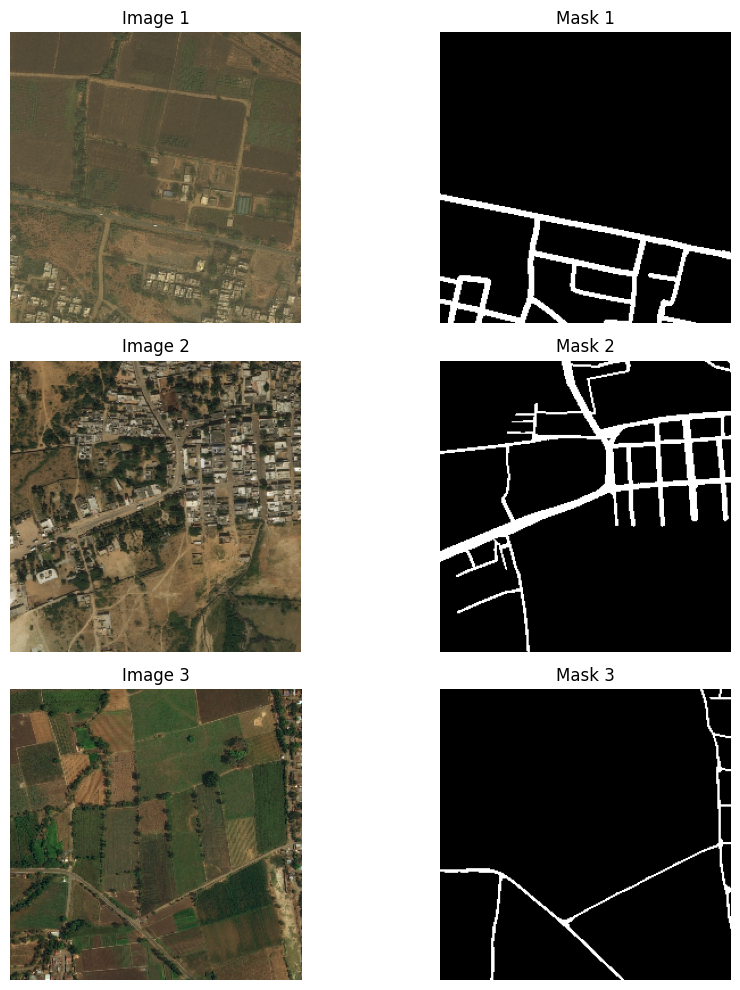

In [75]:
for image_batch, mask_batch in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(3):
        image = image_batch[i].numpy()
        mask = mask_batch[i].numpy().squeeze()

        # Satellite image
        plt.subplot(3, 2, 2*i + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Corresponding mask
        plt.subplot(3, 2, 2*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break